# COGS 118C Final Project

## Setup

In [30]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import scipy

### Read Data

In [2]:
sub1_set = 'data/subject1/sub-01_task-songfamiliarity_eeg.set'

# Read the raw data
raw = mne.io.read_raw_eeglab(sub1_set, preload=True)

# Print the head of the data
print(raw.info)
print(raw[:5][0])

Reading c:\Users\grego\OneDrive\Documents\cogs-118c-song-familiarity\data\subject1\sub-01_task-songfamiliarity_eeg.fdt
Reading 0 ... 1807099  =      0.000 ...  1807.099 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F3, F7, FC5, FC1, FCz, C3, T7, TP9, CP5, CP1, Pz, P3, P7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 1000.0 Hz
>
[[ 6.26690507e-07 -1.36414266e-06 -2.39269257e-06 ...  7.34802551e-05
   7.60795364e-05  7.84163055e-05]
 [ 4.47712212e-05  4.13577881e-05  4.45301132e-05 ... -2.66145658e-06
  -3.80891657e-06 -1.41250744e-07]
 [ 3.79548416e-05  3.37484283e-05  3.93421669e-05 ...  6.94403744e-06
   1.17275648e-05  1.49056187e-05]
 [ 3.40858345e-05  3.10366974e-05  3.39455452e-05 ...  2.52606812e-05
   2.85402775e-05  3.17569542e-05]
 [ 7.62951493e-07 -2.44054031e-06 -1.06173754e-07 ...  2.27950230e-05
   2.10377178e-05  2.03138027e-05]]


### Show Time Series

In [4]:
raw.plot(duration=10, n_channels=raw.info['nchan'], scalings='auto')

Using pyopengl with version 3.1.6


<mne_qt_browser._pg_figure.MNEQtBrowser(0x158dcb530) at 0x35174b5c0>

Channels marked as bad:
none


/Users/gregoryweber/Applications/MNE-Python/1.9.0_0/.mne-python/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


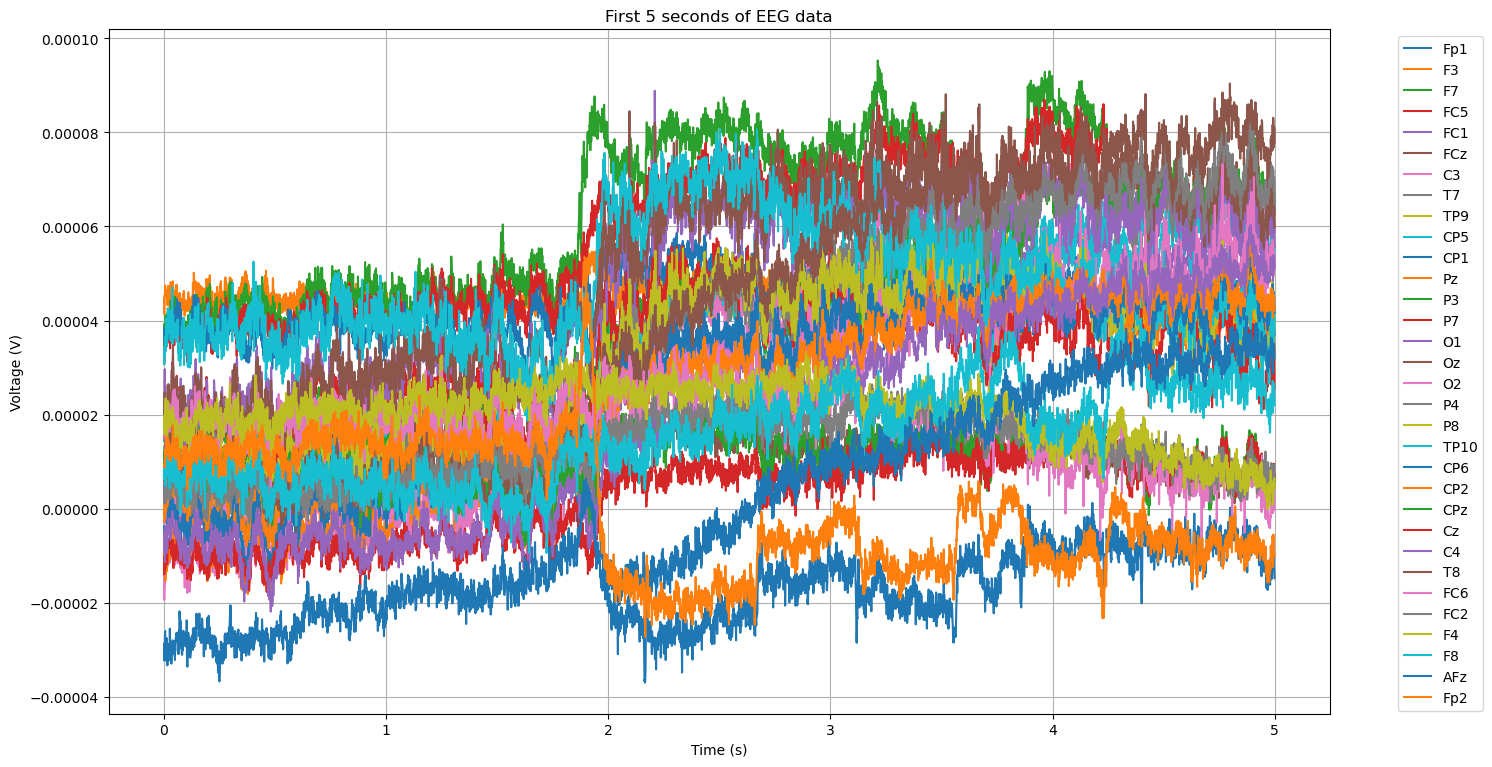

In [8]:
data, times = raw[:, :5000]  # Get first 5 seconds (5000 samples at 1000Hz)
plt.figure(figsize=(15, 8))
for i in range(len(raw.ch_names)):
  plt.plot(times, data[i], label=raw.ch_names[i])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('First 5 seconds of EEG data')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

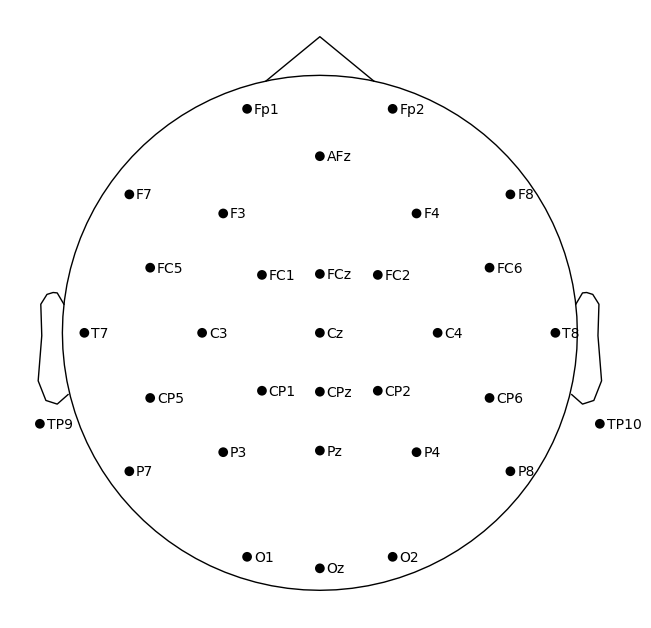


Sensor names:
['Fp1', 'F3', 'F7', 'FC5', 'FC1', 'FCz', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'CPz', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AFz', 'Fp2']


In [9]:
# Plot electrode positions on a head
a = raw.plot_sensors(show_names=True)
print("\nSensor names:")
print(raw.ch_names)

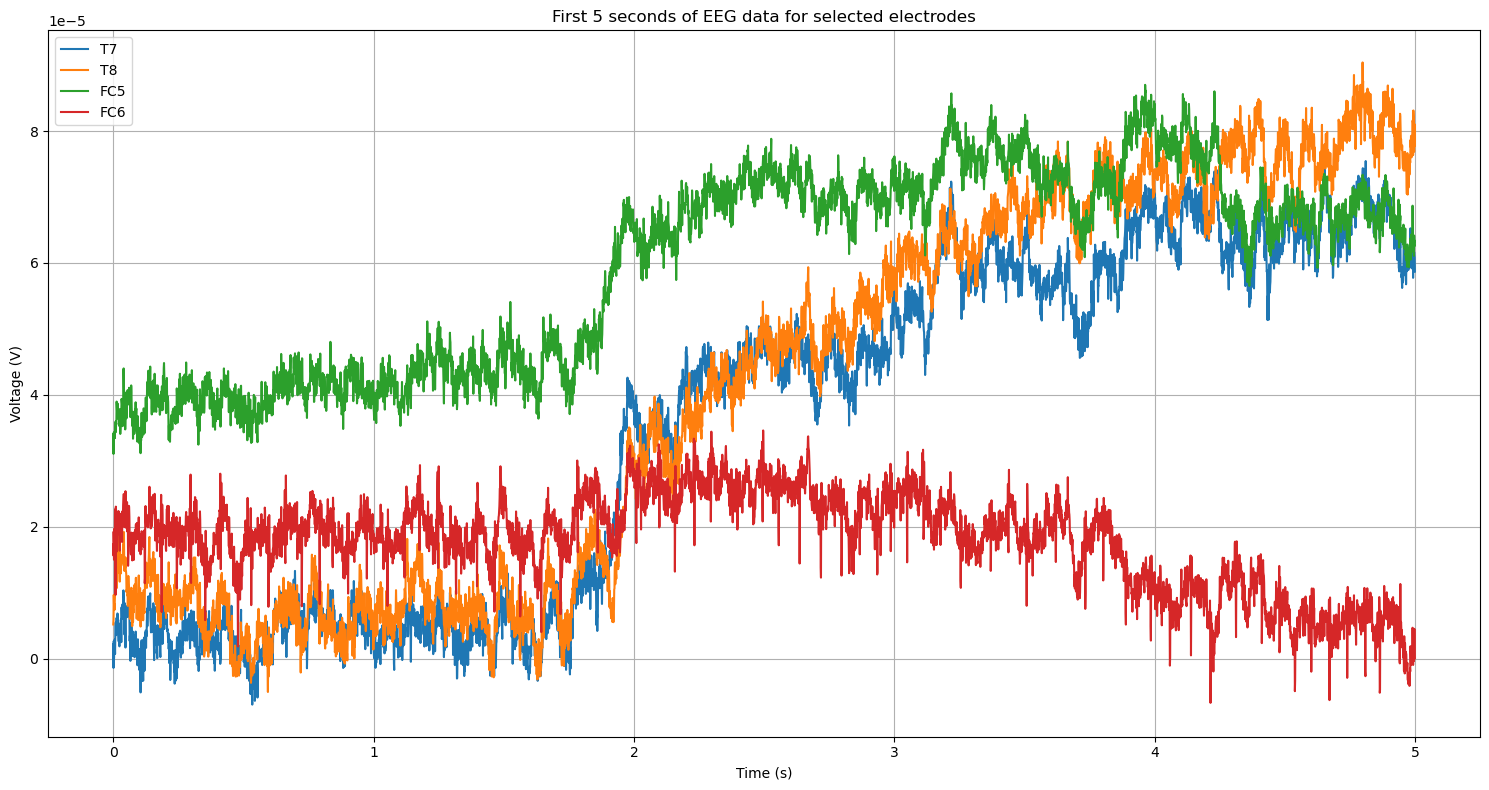

In [10]:
# Graph time series for T7, T8, FC5, and FC6 electrodes, as these are most relevant

# Get the indices of the electrodes
T7_idx = raw.ch_names.index('T7')
T8_idx = raw.ch_names.index('T8')
FC5_idx = raw.ch_names.index('FC5')
FC6_idx = raw.ch_names.index('FC6')

# Get first 5 seconds of data for selected electrodes
data, times = raw[[T7_idx, T8_idx, FC5_idx, FC6_idx], :5000]

plt.figure(figsize=(15, 8))
plt.plot(times, data[0], label='T7')
plt.plot(times, data[1], label='T8')
plt.plot(times, data[2], label='FC5')
plt.plot(times, data[3], label='FC6')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('First 5 seconds of EEG data for selected electrodes')
plt.grid(True)
plt.legend()
plt.tight_layout()

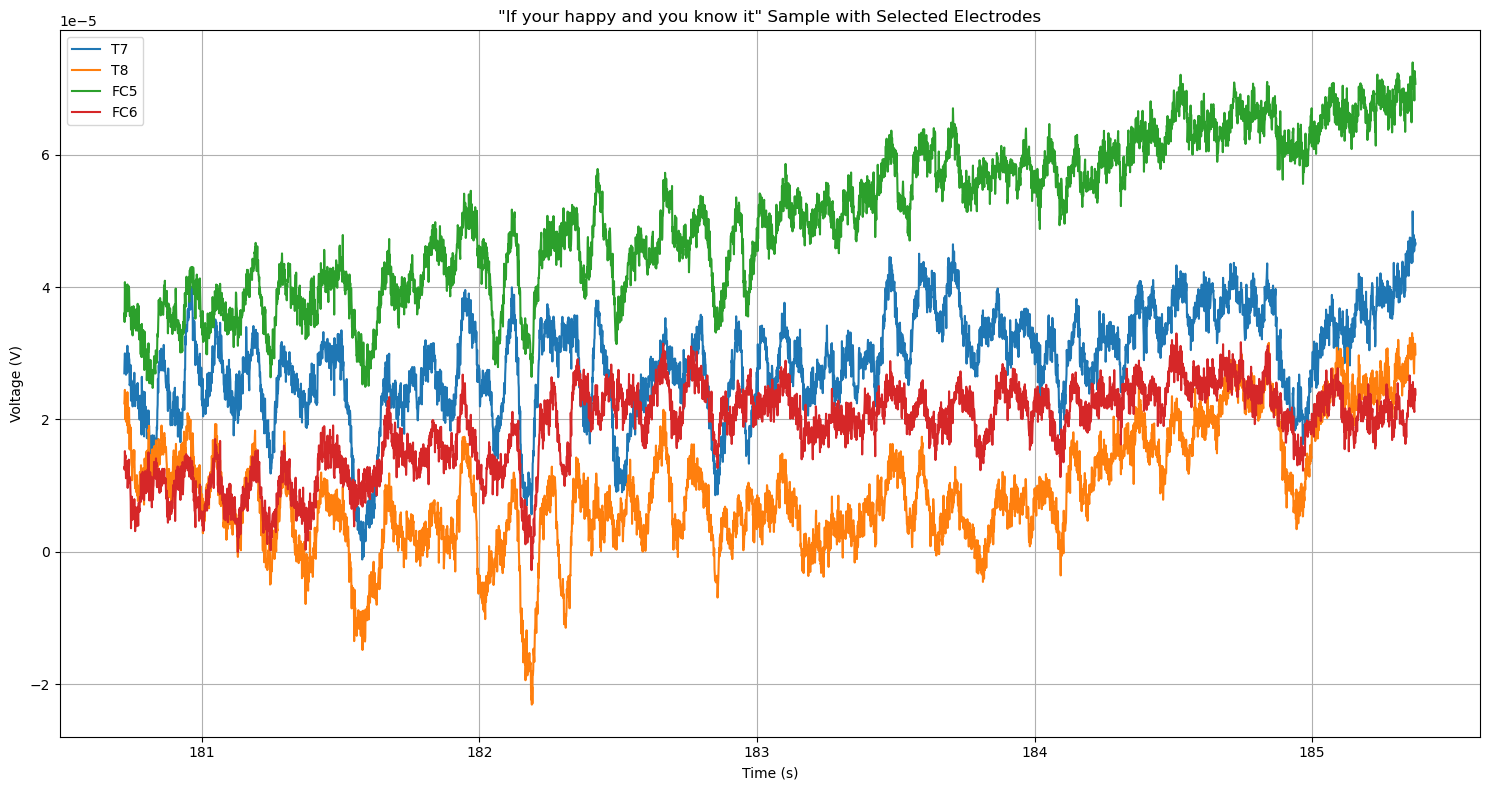

In [6]:
# Look at "if your happy and you know it" song data

T7_idx = raw.ch_names.index('T7')
T8_idx = raw.ch_names.index('T8')
FC5_idx = raw.ch_names.index('FC5')
FC6_idx = raw.ch_names.index('FC6')

data, times = raw[[T7_idx, T8_idx, FC5_idx, FC6_idx], 180721:185373]

plt.figure(figsize=(15, 8))
plt.plot(times, data[0], label='T7')
plt.plot(times, data[1], label='T8')
plt.plot(times, data[2], label='FC5')
plt.plot(times, data[3], label='FC6')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('"If your happy and you know it" Sample with Selected Electrodes')
plt.grid(True)
plt.legend()
plt.tight_layout()

In [5]:
# Import all subject data

sub2_set = 'data/subject2/sub-02_task-songfamiliarity_eeg.set'
sub3_set = 'data/subject3/sub-03_task-songfamiliarity_eeg.set'
sub4_set = 'data/subject4/sub-04_task-songfamiliarity_eeg.set'
sub5_set = 'data/subject5/sub-05_task-songfamiliarity_eeg.set'
sub6_set = 'data/subject6/sub-06_task-songfamiliarity_eeg.set'

raw2 = mne.io.read_raw_eeglab(sub2_set, preload=True)
raw3 = mne.io.read_raw_eeglab(sub3_set, preload=True)
raw4 = mne.io.read_raw_eeglab(sub4_set, preload=True)
raw5 = mne.io.read_raw_eeglab(sub5_set, preload=True)
raw6 = mne.io.read_raw_eeglab(sub6_set, preload=True)

Reading c:\Users\grego\OneDrive\Documents\cogs-118c-song-familiarity\data\subject2\sub-02_task-songfamiliarity_eeg.fdt
Reading 0 ... 2036549  =      0.000 ...  2036.549 secs...
Reading c:\Users\grego\OneDrive\Documents\cogs-118c-song-familiarity\data\subject3\sub-03_task-songfamiliarity_eeg.fdt
Reading 0 ... 1934149  =      0.000 ...  1934.149 secs...
Reading c:\Users\grego\OneDrive\Documents\cogs-118c-song-familiarity\data\subject4\sub-04_task-songfamiliarity_eeg.fdt
Reading 0 ... 1877149  =      0.000 ...  1877.149 secs...
Reading c:\Users\grego\OneDrive\Documents\cogs-118c-song-familiarity\data\subject5\sub-05_task-songfamiliarity_eeg.fdt
Reading 0 ... 1946649  =      0.000 ...  1946.649 secs...
Reading c:\Users\grego\OneDrive\Documents\cogs-118c-song-familiarity\data\subject6\sub-06_task-songfamiliarity_eeg.fdt
Reading 0 ... 1847649  =      0.000 ...  1847.649 secs...


0 7 25 3 26
1 7 25 3 26
2 7 25 3 26
3 7 25 3 26


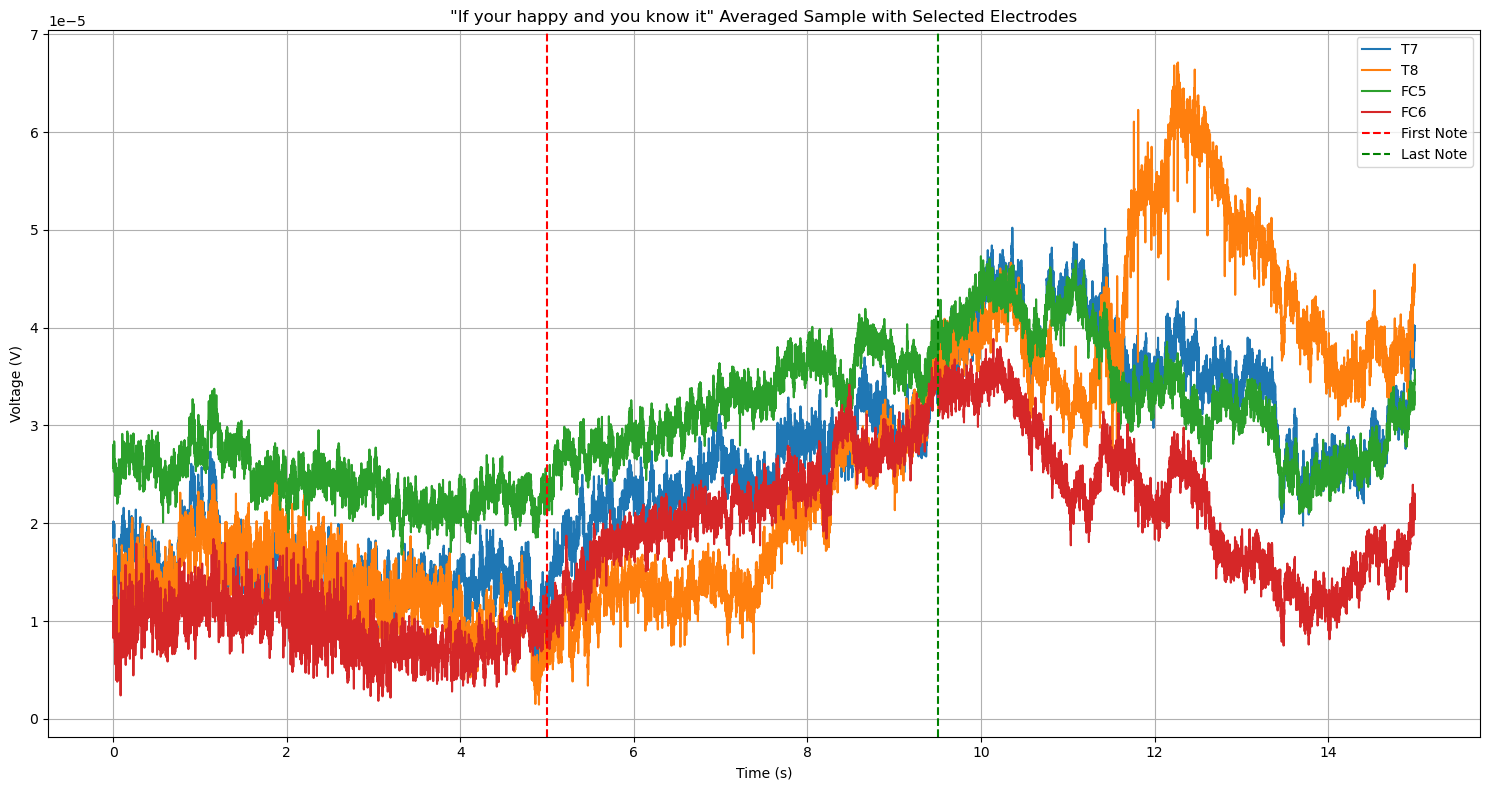

In [16]:
# Average data fom 4 subjects of "if your happy and you know it" sample

average_data = np.zeros((4, 15000))
sample_times = [181721, 1635332, 1637203, 608632]
for idx, r in enumerate([raw, raw3, raw4, raw6]):
  t = sample_times[idx]
  T7_idx = r.ch_names.index('T7')
  T8_idx = r.ch_names.index('T8')
  FC5_idx = r.ch_names.index('FC5')
  FC6_idx = r.ch_names.index('FC6')
  print(idx, T7_idx, T8_idx, FC5_idx, FC6_idx)
  start = sample_times[idx] - 5000
  end = sample_times[idx] + 10000
  data, times = r[[T7_idx, T8_idx, FC5_idx, FC6_idx], start:end]
  average_data += data

average_data /= 5
time = np.linspace(0, 15, 15000)

plt.figure(figsize=(15, 8))
plt.plot(time, average_data[0], label='T7')
plt.plot(time, average_data[1], label='T8')
plt.plot(time, average_data[2], label='FC5')
plt.plot(time, average_data[3], label='FC6')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('"If your happy and you know it" Averaged Sample with Selected Electrodes')
plt.axvline(x=5, color='r', linestyle='--', label='First Note')
plt.axvline(x=9.5, color='g', linestyle='--', label='Last Note')
plt.grid(True)
plt.legend()
plt.tight_layout()

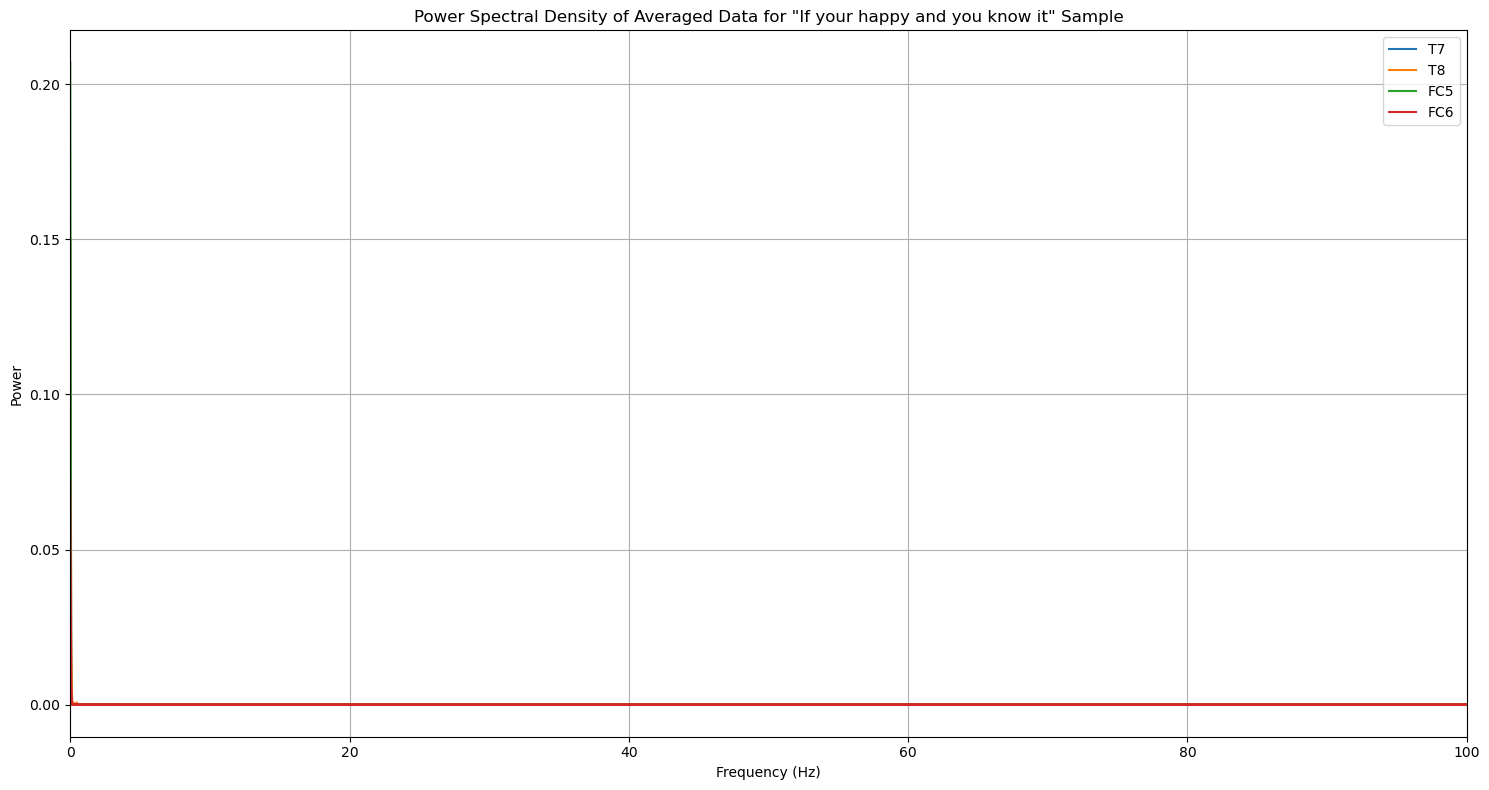

In [50]:
# Plot the spectral density of the averaged data for the "if your happy and you know it" sample

frequencies = np.fft.fftfreq(15000, 1/1000)
fft_data = np.fft.fft(average_data)
fft_data = np.abs(fft_data)**2

plt.figure(figsize=(15, 8))
plt.plot(frequencies, fft_data[0], label='T7')
plt.plot(frequencies, fft_data[1], label='T8')
plt.plot(frequencies, fft_data[2], label='FC5')
plt.plot(frequencies, fft_data[3], label='FC6')
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 100)
plt.ylabel('Power')
plt.title('Power Spectral Density of Averaged Data for "If your happy and you know it" Sample')
plt.grid(True)
plt.legend()
plt.tight_layout()

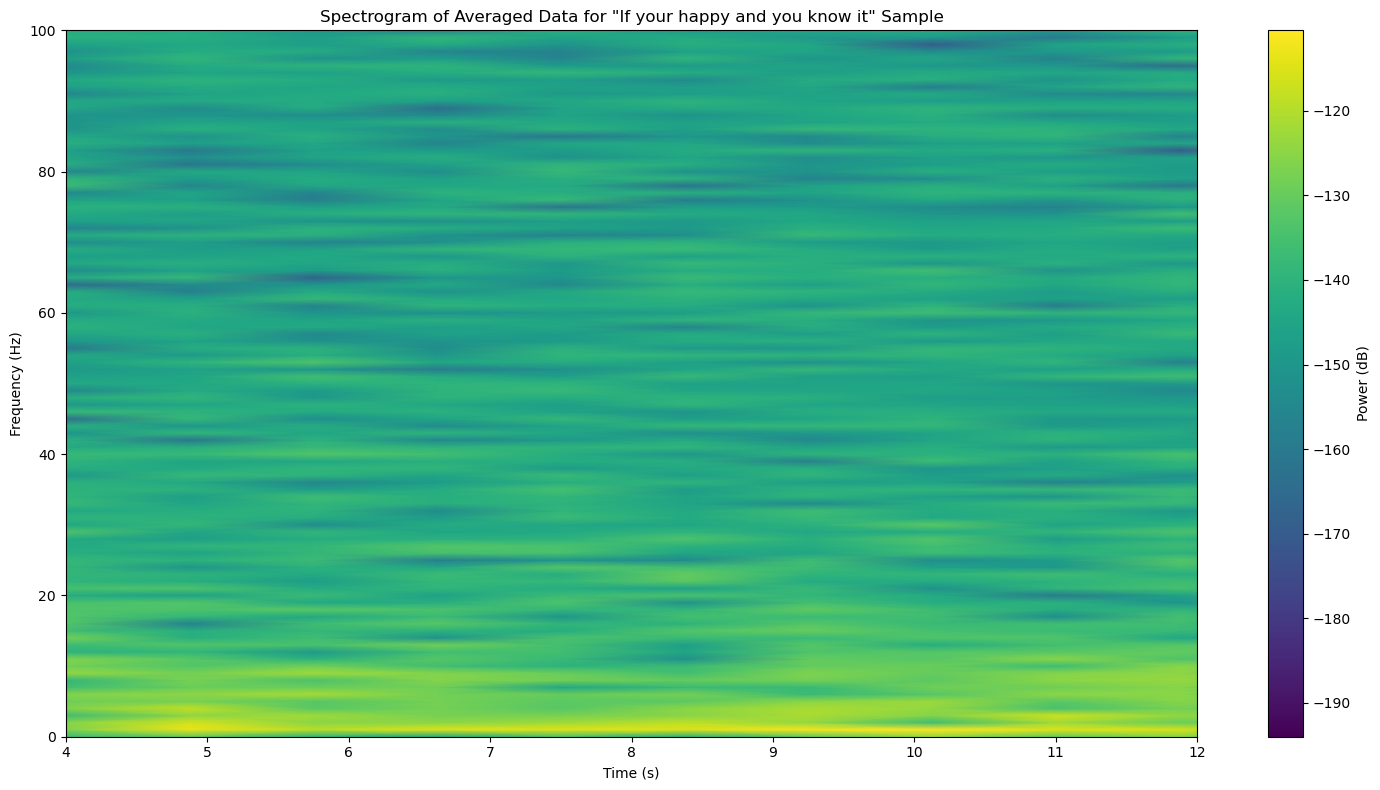

In [47]:
# Spectrogram of the averaged data for the "if your happy and you know it" sample

frequencies, times, Sxx = scipy.signal.spectrogram(average_data, fs=1000, nperseg=1000)
plt.figure(figsize=(15, 8))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx[0]), shading='gouraud')
plt.colorbar(label='Power (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(4, 12)
plt.ylim(0, 100)
plt.title('Spectrogram of Averaged Data for "If your happy and you know it" Sample')
plt.tight_layout()

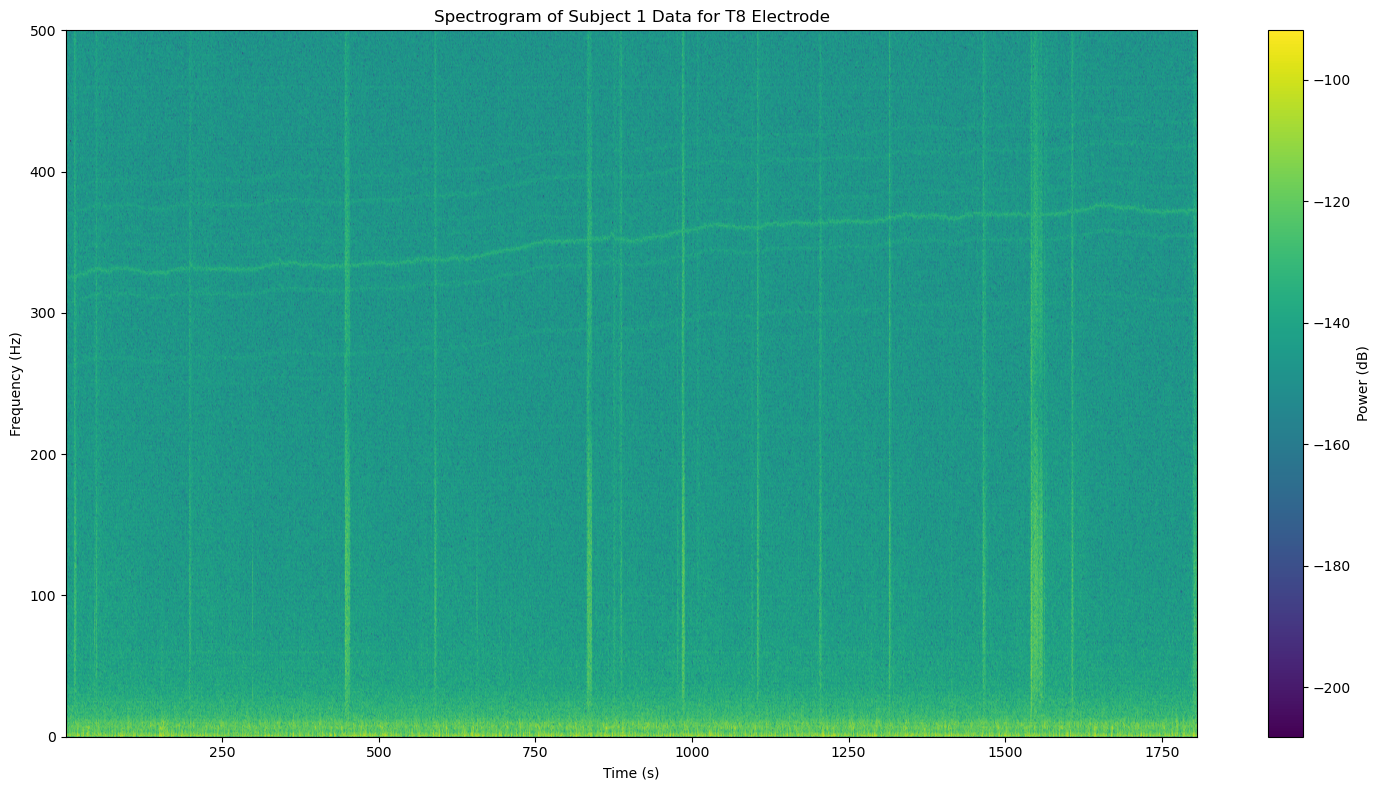

In [59]:
# Plot the spectral density for one subject


frequencies, times, Sxx = scipy.signal.spectrogram(raw[T8_idx][0], fs=1000, nperseg=1000)
plt.figure(figsize=(15, 8))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx[0]), shading='gouraud')
plt.colorbar(label='Power (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram of Subject 1 Data for T8 Electrode')
plt.tight_layout()